<div style="background-color:white">
  <div align="center">
    <img src="../imgs/techfak_logo.jpg" width="400" height="250">
    <hr>
    <img src="../imgs/madi_logo.png" width="230" height="150">
    <h1 style="color:black">Representation Learning For Gait Analysis in Parkinson’s Patients<h1>
    <h2>Visualization Notebook</h2>
  </div>
  <hr>
</div>

### Background:

**Abstract of the project**: 

This project aims to quantify how accurately Morbus Parkinson's can be classified by different types of deep learning architecture without preprocessing the original sensor data. For this purpose, four different architectures (LSTM, ResNet, a basic autoencoder and a ResNet autoencoder) were used to evaluate the accuracy. The data was collected from patients at the University Hospital of Erlangen. Different severity levels of Parkinson's were regarded as being deceased. In this regard, this project performed a binary classification task (healthy and deceased). It shows, that a ResNet autoencoder predicts Parkinson with 87\% accuracy and can be used as a decision support system for doctors. 


### Objective:
**Classify if a patient has the Parkinson's disease or not with patient data from the hospital in Erlangen:** 

Using a real dataset from the hospital in Erlangen, we predict based on a fixed timeseries frame of each patient if this patient has parkinson or not. Based on the UPDRS (Unified Parkinson’s Disease Rating Scale), there exist seven levels of the parkinson desease. For our experiment, we only took into consideration whether or not a patient has parkinson, not how severve the desease is. The trained PyTorch models can be used to classify future patients based on their measured sensor data.

### `Outline of the Notebook`

- [0. Import Packages](#0)

- [1. ResNet](#1)
    - [1.1 Load Checkpoint](#1.1)
    - [1.2 Prediction on Testset](#1.2)
    - [1.3 Visualization](#1.3)
        - [2.3.1 Train and Validation Loss](#2.3.1)
        - [2.3.2 Train and Validation Accuracy](#2.3.2)
        - [2.3.3 Confusion Matrix](#2.3.3)
        
- [2. Autoencoder](#2)
    - [2.1 Load Checkpoint](#2.1)
    - [2.2 Prediction on Testset](#2.2)
    - [2.3 Visualization](#2.3)
        - [2.3.1 Train and Validation Loss](#2.3.1)
        - [2.3.2 Accuracy Threshold](#2.3.2)
        - [2.3.3 Confusion Matrix different Thresholds](#2.3.3)

<a name='0'></a>
## 0. Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from pytorch_lightning.metrics.functional import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import seaborn as sns
import warnings
#import sys
#sys.path.insert(0,'..')
%cd ..
warnings.filterwarnings("ignore")

/Users/timloehr/PycharmProjects/representation-learning-for-gait-analysis-in-parkinson-s-patients


<a name='1'></a>
# 1. ResNet

<a name='1.1'></a>
## 1.1 Load Checkpoint

In [2]:
from models.resnet.ResNet import ResNet
from models.resnet.data import ParkinsonDataModuleResNet

In [3]:
PATH = "../models/resnet/best_model_0.8223379850387573.ckpt"
max_batch_len = 8192

In [4]:
trainer = Trainer(auto_scale_batch_size=False,
                  auto_lr_find=False, 
                  fast_dev_run=False,
                  min_epochs=1,
                  max_epochs=200)
model = ResNet()
#model = model.load_from_checkpoint(PATH)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [5]:
datamodule = ParkinsonDataModuleResNet(batch_size=1, max_batch_len=max_batch_len)
datamodule.prepare_data()
datamodule.setup()

test_df = datamodule.test_dataloader()
val_df = datamodule.val_dataloader()

<a name='1.2'></a>
## 1.2 Prediction on Testset

In [ ]:
def test(loader):
    for X, y in loader:
        outputs = model(X)
        acc = (y == torch.round(outputs)).sum()
        acc = acc / len(outputs)
        mat = confusion_matrix(torch.round(outputs), labels, 2)
        #print(mat)
        print(acc)

In [ ]:
test(test_df)

<a name='1.3'></a>
# 1.3 Visualization

<a name='1.3.1'></a>
## 1.3.1 Train and Validation Loss

In [ ]:
from IPython.display import Image
Image("../models/resnet/train_loss_resnet.png")

In [ ]:
Image("../models/resnet/validation_loss_resnet.png")

<a name='1.3.2'></a>
## 1.3.2 Train and Validation Accuracy

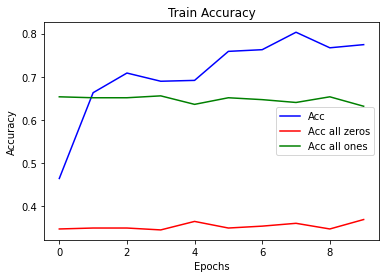

In [34]:
Image("../models/resnet/train_accuracy_resnet.png")

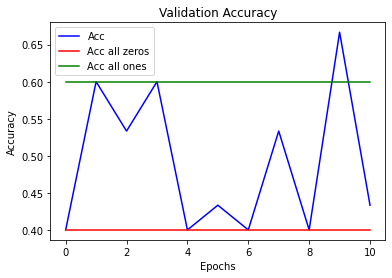

In [35]:
Image("../models/resnet/validation_accuracy_resnet.png")

<a name='1.3.3'></a>
## 1.3.3 Confusion Matrix

In [ ]:
def test_visualization(loader):
    for X, y in loader:
        outputs = model(X)
        acc = (y == torch.round(outputs)).sum()
        acc = acc / len(outputs)
        mat = confusion_matrix(torch.round(outputs), labels, 2)
        print(mat)
        print(acc)      
        fig, axes = plt.subplots(1, 1, figsize=(16,12))

        df_cm1 = pd.DataFrame(data=mat.numpy(), columns=["Healthy", "Parkinson"], index=["Healthy", "Parkinson"]).astype(int)
        heatmap = sns.heatmap(df_cm1, annot=True, fmt="d", ax=axes)
        axes.set_xlabel("True Labels", fontsize=15)
        axes.set_ylabel("Predicted Labels", fontsize=15)

        plt.show()

In [ ]:
test_visualization(test_df)

<a name='2'></a>
# 2. Autoencoder

<a name='2.1'></a>
## 2.1 Load Checkpoint

In [6]:
from models.autoencoder_loss.autoencoder import ParkinsonResNetAutoEncoder
from models.autoencoder_loss.data import ParkinsonResNetDataModuleAE

In [7]:
PATH = "./models/autoencoder_loss/checkpoints/training_0/ResNet_Autoencoder_new.ckpt"
max_batch_len = 8192
batch_size = 4
lr = 0.01

datamodule = ParkinsonResNetDataModuleAE(batch_size=batch_size, max_batch_len=max_batch_len)
model = ParkinsonResNetAutoEncoder(learning_rate=lr, max_batch_len=max_batch_len)

In [8]:
trainer = Trainer(auto_scale_batch_size=False,
                  auto_lr_find=False, 
                  fast_dev_run=False,
                  min_epochs=1,
                  max_epochs=200)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [9]:
model = model.load_from_checkpoint(PATH)

In [10]:
datamodule.prepare_data()
datamodule.setup()
test_loader = datamodule.test_dataloader()

In [11]:
trainer.test(model, test_loader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2436823050181071}
--------------------------------------------------------------------------------


[{'test_loss': 0.2436823050181071}]

### Datamodule

In [12]:
datamodule = ParkinsonResNetDataModuleAE(batch_size=1, max_batch_len=max_batch_len)
datamodule.prepare_data()
datamodule.setup()

threshold = 0.2
test_df = datamodule.test_dataloader()
val_df = datamodule.val_dataloader()

<a name='2.2'></a>
## 2.2 Prediction on Testset

In [13]:
def autoencoder_loss_prediction(loader, threshold):
    labels = []
    targets = []

    for X, y in loader:
        X = X.view(1, 1, max_batch_len, 12)
        X_hat = model(X).view(-1, *X.shape)

        loss = F.mse_loss(X_hat, X)

        target = 0 if loss < threshold else 1

        labels.append(y)
        targets.append(target)

        #print(f"Rec. Loss: {np.round(float(loss), 2)} - Label: {y}")

    labels = np.array(labels)
    targets = np.array(targets)
    accuracy = accuracy_score(labels, targets)
    #print(f"Accuracy: {np.round(accuracy, 2)*100}%")
    return accuracy

In [14]:
autoencoder_loss_prediction(test_df, 0.2)

0.8695652173913043

<a name='2.3'></a>
## 2.3 Visualizations

<a name='2.3.1'></a>
## 2.3.1 Train and Validation Loss 

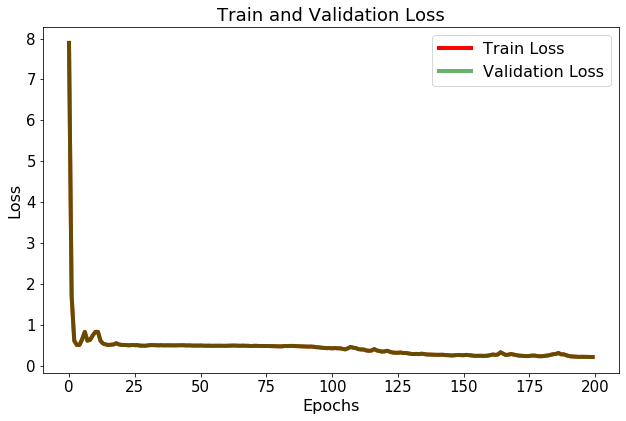

In [27]:
losses = pd.read_csv("data/autoencoder_loss/losses_df.csv")

train_losses = np.array(losses["Train_Loss"]) 
val_losses = np.array(losses["Val_Loss"])

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.plot(train_losses, color="red", label="Train Loss", linewidth=4)
ax.plot(val_losses, color="green", label="Validation Loss", alpha=0.6, linewidth=4)
ax.set_title("Train and Validation Loss", fontsize=18)
ax.set_ylabel("Loss", fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
ax.legend(fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

<a name='2.3.2'></a>
## 2.3.2 Accuracy Threshold

In [16]:
test_accs = []
val_accs = []

for threshold in np.arange(0.1, 0.8, 0.1):
    test_accs.append(autoencoder_loss_prediction(test_df, threshold))
    val_accs.append(autoencoder_loss_prediction(val_df, threshold))

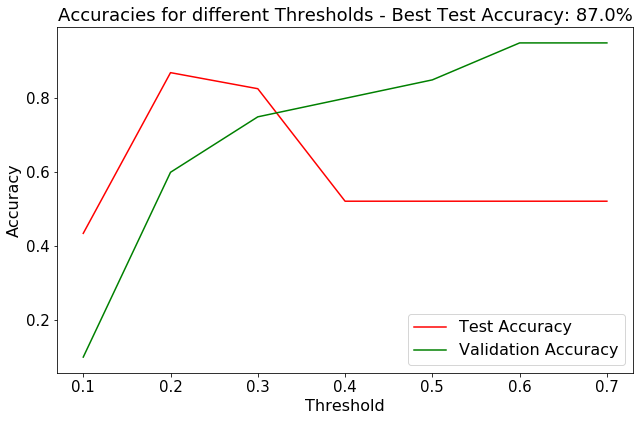

In [28]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

max_acc = np.round(np.max(test_accs), 3)*100

ax.plot(test_accs, color="red", label="Test Accuracy")
ax.plot(val_accs, color="green", label="Validation Accuracy")
ax.set_title(f"Accuracies for different Thresholds - Best Test Accuracy: {max_acc}%", fontsize=18)
ax.set_xticklabels(np.arange(0, 0.8, 0.1).astype("float16"))
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="lower right", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

<a name='2.3.3'></a>
## 2.3.3 Confusion Matrix different Thresholds

In [18]:
threshold_1 = 0.2
threshold_2 = 0.3
threshold_3 = 0.4
threshold_4 = 0.5

nb_classes = 2
confusion_matrix_0_2 = np.zeros((nb_classes, nb_classes))
confusion_matrix_0_3 = np.zeros((nb_classes, nb_classes))
confusion_matrix_0_4 = np.zeros((nb_classes, nb_classes))
confusion_matrix_0_5 = np.zeros((nb_classes, nb_classes))

for X, y in test_df:
    X = X.view(1, 1, max_batch_len, 12)
    X_hat = model(X).view(-1, *X.shape)

    loss = F.mse_loss(X_hat, X)
    target1 = 0 if loss < threshold_1 else 1
    target2 = 0 if loss < threshold_2 else 1
    target3 = 0 if loss < threshold_3 else 1
    target4 = 0 if loss < threshold_4 else 1
    
    confusion_matrix_0_2[y.long(), target1] += 1
    confusion_matrix_0_3[y.long(), target2] += 1
    confusion_matrix_0_4[y.long(), target3] += 1
    confusion_matrix_0_5[y.long(), target4] += 1
    
acc_0_2 = np.round(test_accs[1], 2)*100
acc_0_3 = np.round(test_accs[2], 2)*100
acc_0_4 = np.round(test_accs[3], 2)*100
acc_0_5 = np.round(test_accs[4], 2)*100

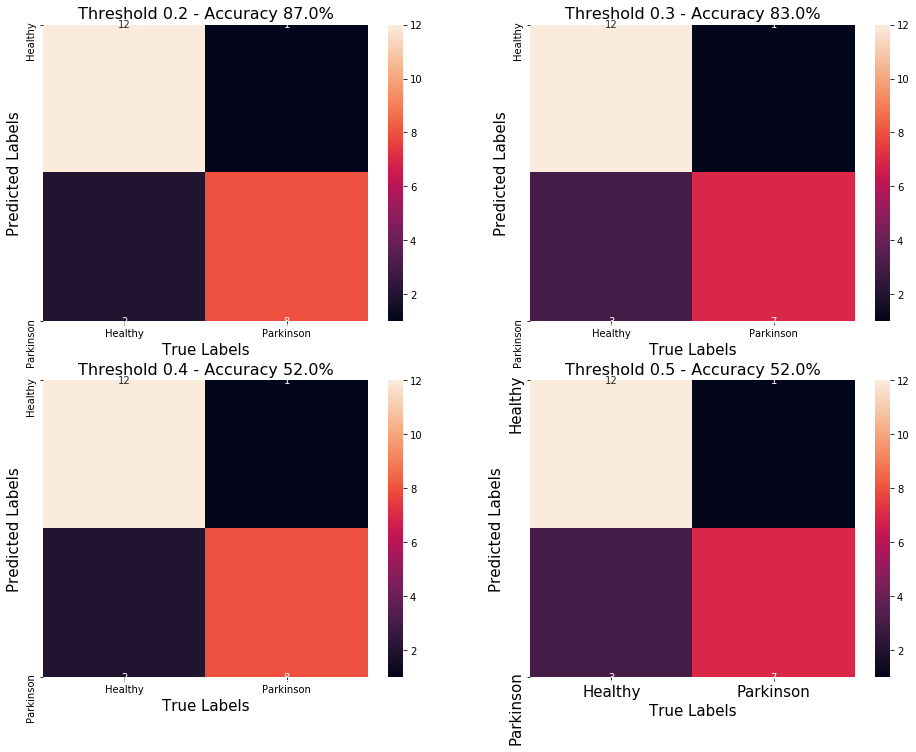

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16,12))

df_cm1 = pd.DataFrame(data=confusion_matrix_0_2, columns=["Healthy", "Parkinson"], index=["Healthy", "Parkinson"]).astype(int)
heatmap = sns.heatmap(df_cm1, annot=True, fmt="d", ax=axes[0,0])
axes[0,0].set_title(f"Threshold {threshold_1} - Accuracy {acc_0_2}%", fontsize=16)
axes[0,0].set_xlabel("True Labels", fontsize=15)
axes[0,0].set_ylabel("Predicted Labels", fontsize=15)

df_cm2 = pd.DataFrame(data=confusion_matrix_0_3, columns=["Healthy", "Parkinson"], index=["Healthy", "Parkinson"]).astype(int)
heatmap = sns.heatmap(df_cm2, annot=True, fmt="d", ax=axes[0,1])
axes[0,1].set_title(f"Threshold {threshold_2} - Accuracy {acc_0_3}%", fontsize=16)
axes[0,1].set_xlabel("True Labels", fontsize=15)
axes[0,1].set_ylabel("Predicted Labels", fontsize=15)

df_cm3 = pd.DataFrame(data=confusion_matrix_0_4, columns=["Healthy", "Parkinson"], index=["Healthy", "Parkinson"]).astype(int)
heatmap = sns.heatmap(df_cm1, annot=True, fmt="d", ax=axes[1,0])
axes[1,0].set_title(f"Threshold {threshold_3} - Accuracy {acc_0_4}%", fontsize=16)
axes[1,0].set_xlabel("True Labels", fontsize=15)
axes[1,0].set_ylabel("Predicted Labels", fontsize=15)

df_cm4 = pd.DataFrame(data=confusion_matrix_0_5, columns=["Healthy", "Parkinson"], index=["Healthy", "Parkinson"]).astype(int)
heatmap = sns.heatmap(df_cm2, annot=True, fmt="d", ax=axes[1,1])
axes[1,1].set_title(f"Threshold {threshold_4} - Accuracy {acc_0_5}%", fontsize=16)
axes[1,1].set_xlabel("True Labels", fontsize=15)
axes[1,1].set_ylabel("Predicted Labels", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

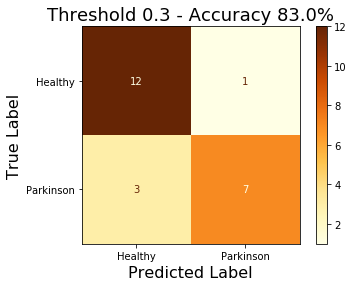

In [57]:
cmd = ConfusionMatrixDisplay(confusion_matrix_0_3, display_labels=['Healthy','Parkinson'])
cmd.plot(cmap='YlOrBr')
plt.title(f"Threshold {threshold_2} - Accuracy {acc_0_3}%", fontsize=18)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.show()